In [2]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.externals import joblib
import lightgbm as lgb

mpl.rcParams['figure.figsize'] = (16,12)

## Session and Project

In [3]:
from neptune.sessions import Session
project = Session().get_project('neptune-ml/credit-default-prediction')

## Fetch experiments

In [20]:
experiments = project.get_experiments(id=['CRED-55','CRED-54', 'CRED-80', 'CRED-81', 'CRED-83'])
experiments

[Experiment(CRED-54),
 Experiment(CRED-55),
 Experiment(CRED-80),
 Experiment(CRED-81),
 Experiment(CRED-83)]

## Fetch experiment channels

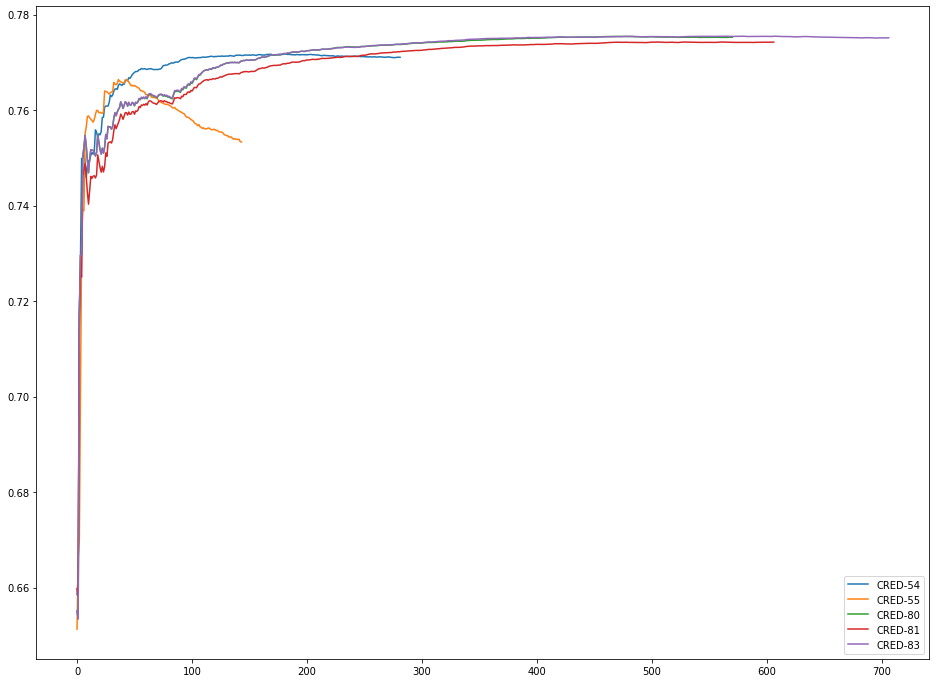

In [5]:
fig, ax = plt.subplots()
for exp in experiments:
    df = exp.get_numeric_channels_values('valid_iter_auc')
    ax.plot(df.x, df.valid_iter_auc, label=exp.id)
plt.legend()
plt.show()

# Best Model 
Let's take a look at the best experiment 
## Model training and parameters

In [6]:
exp = project.get_experiments(id=['CRED-83'])[0]
exp

Experiment(CRED-83)

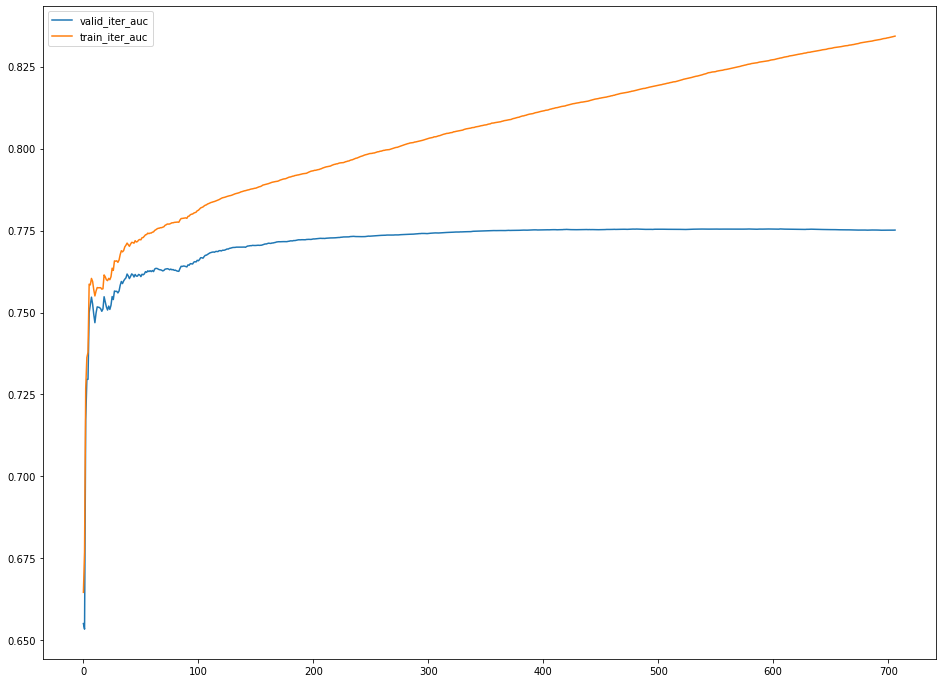

In [7]:
fig, ax = plt.subplots()
df = exp.get_numeric_channels_values('train_iter_auc','valid_iter_auc')
ax.plot(df.x, df.valid_iter_auc, label='valid_iter_auc')
ax.plot(df.x, df.train_iter_auc, label='train_iter_auc')
plt.legend()
plt.show()

## Experiment details

In [7]:
exp.get_properties()

{'features_path': 'data/processed/features_joined_v1.csv',
 'features_version': 'e1f5a473fedb57d12a792c02cc52993d',
 'train_split_version': '41bf231b7dc76abb7a2fe15e5cbd9d20',
 'valid_split_version': '4b61d05c05aa16f71015614e3e3b1d1a',
 'model_path': 'models/weights/model.pkl',
 'model_version': '3afb088f79c61123be5bf94aadd4d719'}

## Experiment hyper parameters

In [8]:
exp.get_parameters()

{'num_boost_round': 1000.0,
 'early_stopping_rounds': 100.0,
 'metric': 'auc',
 'seed': 1234.0,
 'num_threads': 2.0,
 'learning_rate': 0.014,
 'max_depth': 19.0,
 'num_leaves': 100.0,
 'min_data_in_leaf': 102.0,
 'feature_fraction': 0.27,
 'subsample': 0.912}

## Experiment artifacts

In [9]:
exp.download_artifact('model.pkl', '../models/temp')
model = joblib.load('../models/temp/model.pkl')

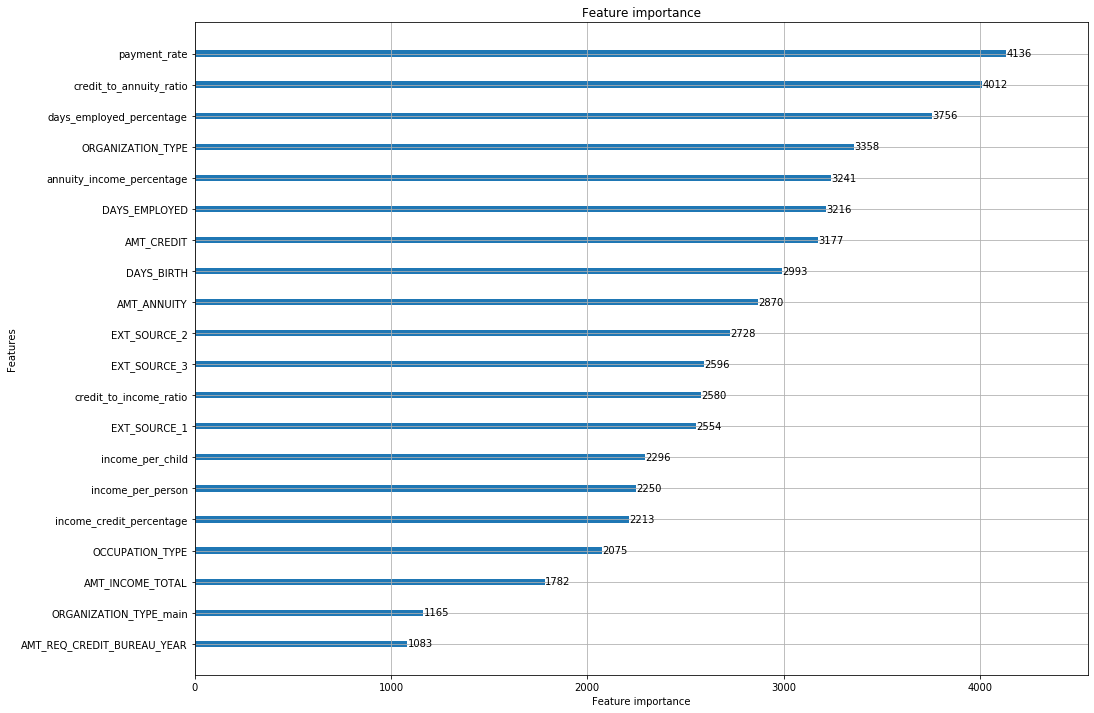

In [10]:
ax = lgb.plot_importance(model, max_num_features=20)

## Model predictions

In [11]:
exp.download_artifact('train_preds.csv', '../models/temp')
exp.download_artifact('valid_preds.csv', '../models/temp')

train_preds = pd.read_csv('../models/temp/train_preds.csv')
valid_preds = pd.read_csv('../models/temp/valid_preds.csv')

In [12]:
valid_preds.head()

,SK_ID_CURR,TARGET,preds_neg,preds_pos
0,455858,0,0.938656,0.061344
1,268345,0,0.935881,0.064119
2,426693,0,0.816487,0.183513
3,221937,0,0.797157,0.202843
4,426636,0,0.931415,0.068585


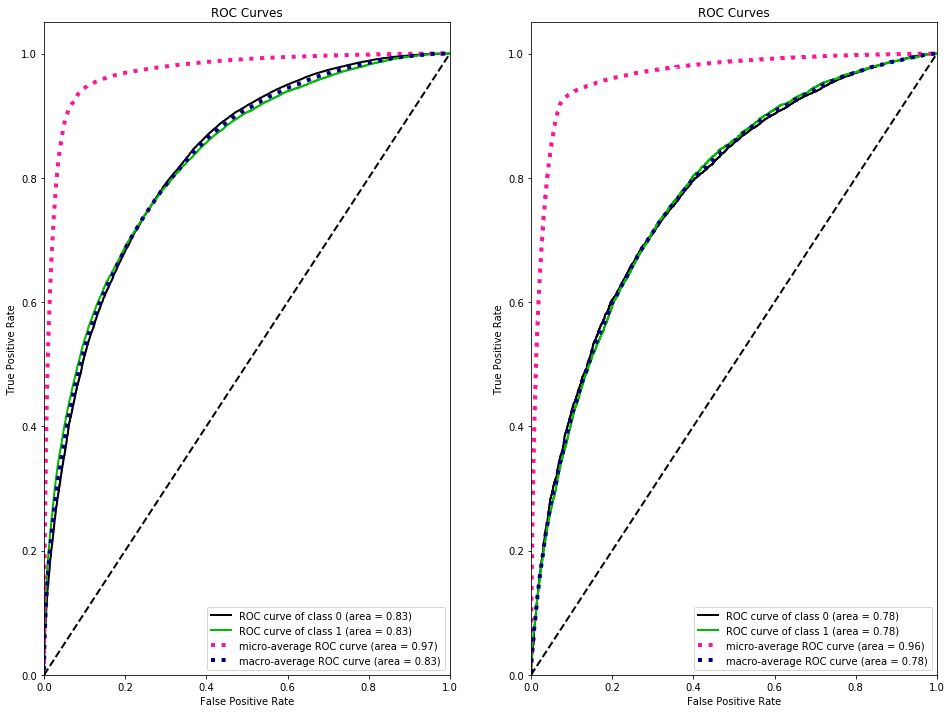

In [13]:
from scikitplot.metrics import plot_roc

fig, axs = plt.subplots(1,2)
plot_roc(train_preds['TARGET'], train_preds[['preds_neg','preds_pos']], ax=axs[0])
plot_roc(valid_preds['TARGET'], valid_preds[['preds_neg','preds_pos']], ax=axs[1])
plt.show()

# Worst results

Let's get worst predictions from the validation set.

In [14]:
valid_preds['abs_error'] = abs(valid_preds['TARGET']-valid_preds['preds_pos'])

worst_valid_ids = valid_preds[['SK_ID_CURR','abs_error']]
worst_valid_ids.head()

,SK_ID_CURR,abs_error
0,455858,0.061344
1,268345,0.064119
2,426693,0.183513
3,221937,0.202843
4,426636,0.068585


In [15]:
exp.get_properties()

{'features_path': 'data/processed/features_joined_v1.csv',
 'features_version': 'e1f5a473fedb57d12a792c02cc52993d',
 'train_split_version': '41bf231b7dc76abb7a2fe15e5cbd9d20',
 'valid_split_version': '4b61d05c05aa16f71015614e3e3b1d1a',
 'model_path': 'models/weights/model.pkl',
 'model_version': '3afb088f79c61123be5bf94aadd4d719'}

In [16]:
features = pd.read_csv('../data/processed/features_joined_v1.csv')

In [17]:
valid_errors = pd.merge(valid_preds[['SK_ID_CURR','abs_error']], features, on='SK_ID_CURR')

In [18]:
valid_errors.sort_values('abs_error', ascending=False, inplace=True)
valid_errors.head(10)

,SK_ID_CURR,abs_error,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_DAY,EXT_SOURCE_2,CNT_FAM_MEMBERS,AMT_CREDIT,CNT_CHILDREN,EXT_SOURCE_3,...,NAME_INCOME_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,ORGANIZATION_TYPE_main,ORGANIZATION_TYPE_subtype,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_total_customer_debt,bureau_total_customer_credit,bureau_total_customer_overdue
51136,405180,1.012354,0.0,0.0,0.0,0.730605,2.0,1350000.0,0.0,0.792264,...,7,6,4,3,5,12,2,940117.500,6.470364e+06,0.0
6097,415611,1.012271,0.0,0.0,0.0,0.679484,2.0,270000.0,0.0,0.621226,...,1,5,5,3,6,10,3,4217745.285,5.200541e+06,0.0
967,183827,1.008275,0.0,0.0,0.0,0.574856,3.0,1161000.0,1.0,0.621226,...,7,10,46,32,5,11,3,0.000,3.914417e+06,0.0
2304,113817,1.004975,1.0,0.0,0.0,0.675686,2.0,1232793.0,0.0,0.670652,...,4,6,31,17,13,3,2,2200099.500,2.808320e+06,0.0
17846,446853,1.002921,0.0,0.0,0.0,0.744395,2.0,1546020.0,0.0,0.758393,...,1,6,50,32,9,4,1,5136259.275,1.341900e+07,0.0
22112,371447,1.001565,0.0,0.0,0.0,0.727517,2.0,1305000.0,0.0,0.684828,...,1,4,5,3,6,10,3,3415497.120,8.596492e+06,0.0
40630,421892,1.001093,0.0,0.0,0.0,0.675436,3.0,234576.0,1.0,0.791075,...,1,16,41,28,13,9,2,1126937.700,5.139873e+06,0.0
47012,329751,1.000995,1.0,0.0,0.0,0.781250,3.0,248760.0,1.0,0.591977,...,7,8,51,32,10,1,1,0.000,2.602845e+05,0.0
28999,267695,1.000863,0.0,0.0,0.0,0.736117,2.0,876019.5,0.0,0.647977,...,1,10,5,3,6,9,1,203103.000,6.173488e+06,0.0
1431,321282,1.000552,0.0,0.0,0.0,0.702687,2.0,508495.5,0.0,0.807274,...,1,18,5,3,6,9,2,0.000,1.972580e+06,0.0


In [19]:
valid_errors.sort_values('abs_error', ascending=True, inplace=True)
valid_errors.head(10)

,SK_ID_CURR,abs_error,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_DAY,EXT_SOURCE_2,CNT_FAM_MEMBERS,AMT_CREDIT,CNT_CHILDREN,EXT_SOURCE_3,...,NAME_INCOME_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,ORGANIZATION_TYPE_main,ORGANIZATION_TYPE_subtype,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_total_customer_debt,bureau_total_customer_credit,bureau_total_customer_overdue
48544,220929,5.931952e-07,0.0,0.0,0.0,0.554784,3.0,1350000.0,1.0,0.634706,...,1,14,46,32,5,1,1,0.00,87511.500,0.0
39770,295420,1.966154e-06,0.0,0.0,0.0,0.729277,2.0,450000.0,0.0,0.646330,...,7,3,42,29,13,7,2,551.88,1562967.000,0.0
43234,325658,8.797658e-06,0.0,0.0,0.0,0.602126,2.0,225000.0,0.0,0.497469,...,1,3,28,14,13,18,3,312187.50,3491922.780,0.0
45221,445605,1.122123e-05,0.0,0.0,0.0,0.682737,2.0,253737.0,0.0,0.785052,...,7,18,5,3,6,2,1,0.00,1085093.775,0.0
4494,367042,1.206076e-05,0.0,0.0,0.0,0.726670,4.0,178290.0,2.0,0.647977,...,1,8,53,33,5,2,2,4085023.50,5868450.000,0.0
19504,166201,1.560314e-05,0.0,0.0,0.0,0.589414,2.0,755190.0,0.0,NaN,...,4,3,33,20,13,2,1,0.00,1422000.000,0.0
10890,391666,1.624580e-05,0.0,2.0,0.0,0.698457,2.0,288873.0,0.0,0.624615,...,7,0,3,3,0,1,1,0.00,48591.000,0.0
44460,226118,1.701480e-05,0.0,0.0,0.0,0.658197,2.0,603000.0,0.0,0.643026,...,1,18,5,3,6,4,2,27252.00,394337.880,0.0
11825,387710,1.884508e-05,0.0,0.0,0.0,0.746776,1.0,95940.0,0.0,0.652897,...,3,18,57,19,13,1,1,0.00,157500.000,0.0
1898,184167,2.032906e-05,0.0,0.0,0.0,0.549582,4.0,254700.0,2.0,0.577969,...,4,3,28,14,13,3,1,51817.50,1318302.000,0.0
